# Extrapolate bias-corrected TF from EN4 grid to ISMIP
Based on Donald's code for extrapolating ocean properties.  Accounts for effective depth using lookup table.

21 Jul 2025 | EHU
- 24 Jul: Attempt with xarray functionality, as NetCDF complaining about shape of grid.  Tried to convert coords on a single slice, but this did not work.  Try making meshgrid?  Or try CESM test case instead of EN4?

In [1]:
# libraries
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
from netCDF4 import Dataset
import os
from pyproj import Transformer
from scipy.interpolate import interp1d


In [2]:
## load effective geometry (spatial look-up table)

# files
xy_eff_file = 'XY_eff.nc'
z_eff_file = 'z_eff.nc'

# effective geometry
# NB replace masked values with NaNs
X_eff = nc.Dataset(xy_eff_file).variables['X_eff'][:].filled(np.nan)
Y_eff = nc.Dataset(xy_eff_file).variables['Y_eff'][:].filled(np.nan)
z_eff = nc.Dataset(z_eff_file).variables['z_eff'][:].filled(np.nan)

# ismip coordinates at which effective geometry applies
x = nc.Dataset(xy_eff_file).variables['x'][:].filled(np.nan)
y = nc.Dataset(xy_eff_file).variables['y'][:].filled(np.nan)
X, Y = np.meshgrid(x, y)

# vertical grid of effective depths
z = np.flipud(np.unique(z_eff[z_eff<=0]))


We are going to load in EN4 data to test the workflow.  Eventually, we will load in CMIP-derived thermal forcing.  Unlike Donald's original workflow, we are loading in pre-computed TF rather than ocean properties.

Note 22 Jul: Donald's workflow using NetCDF and pyproj had an error saying the size of the lat, lon, time dimensions were inconsistent.  Try with `rioxarray` instead, since this is already in the workflow.

Load Hadley:

In [3]:
## load and process data
import rioxarray
import xarray
import rasterio

## files
en4file = '/Users/eultee/Library/CloudStorage/OneDrive-NASA/Data/gris-iceocean-outfiles/tf-Hadley-1950_2020.nc'

ds_en4 = xr.open_dataset(en4file, decode_times='timeDim')

ds_slice = ds_en4.sel(depth=500, method='nearest')

WGS84 = rasterio.crs.CRS.from_epsg(4326)
ds_slice.rio.write_crs(WGS84, inplace=True).rio.set_spatial_dims(
    x_dim='lon',
    y_dim='lat',
    inplace=True,
).rio.write_coordinate_system(inplace=True)

ds_slice

<xarray.Dataset> Size: 19MB
Dimensions:      (lat: 30, lon: 91, time: 852)
Coordinates:
    depth        float32 4B 540.5
  * lat          (lat) float32 120B 57.0 58.0 59.0 60.0 ... 83.0 84.0 85.0 86.0
  * lon          (lon) float32 364B 1.0 2.0 3.0 4.0 ... 357.0 358.0 359.0 360.0
  * time         (time) datetime64[ns] 7kB 1950-01-16T12:00:00 ... 2020-12-16...
    spatial_ref  int64 8B 0
Data variables:
    TF           (time, lat, lon) float64 19MB ...
Attributes:
    title:          Ocean thermal forcing for Hadley
    summary:        TF computed following Verjans code, in a bounding box aro...
    institution:    NASA Goddard Space Flight Center
    creation_date:  2025-04-09 16:26:37

In [4]:
ds_polar = ds_slice.rio.reproject("EPSG:3413")

In [5]:
ds_polar

<xarray.Dataset> Size: 306MB
Dimensions:      (x: 211, y: 213, time: 852)
Coordinates:
  * x            (x) float64 2kB -3.676e+06 -3.641e+06 ... 3.638e+06 3.673e+06
  * y            (y) float64 2kB 3.714e+06 3.679e+06 ... -3.67e+06 -3.705e+06
    depth        float32 4B 540.5
  * time         (time) datetime64[ns] 7kB 1950-01-16T12:00:00 ... 2020-12-16...
    spatial_ref  int64 8B 0
Data variables:
    TF           (time, y, x) float64 306MB nan nan nan nan ... nan nan nan nan
Attributes:
    title:          Ocean thermal forcing for Hadley
    summary:        TF computed following Verjans code, in a bounding box aro...
    institution:    NASA Goddard Space Flight Center
    creation_date:  2025-04-09 16:26:37

In [3]:
# ## load and process data

# # files
# en4file = '/Users/eultee/Library/CloudStorage/OneDrive-NASA/Data/gris-iceocean-outfiles/tf-Hadley-1950_2020.nc'

# # cmip model coordinates
# lat_model = nc.Dataset(en4file).variables['lat'][:].filled(np.nan)
# lon_model = nc.Dataset(en4file).variables['lon'][:].filled(np.nan)
# z_model = nc.Dataset(en4file).variables['depth'][:].filled(np.nan)
# t_model = nc.Dataset(en4file).variables['time'][:].filled(np.nan)

# # get coordinates in EPSG:3413 for consistency with ismip grid
# mapping = Transformer.from_crs("epsg:4326", "epsg:3413", always_xy=True)
# x_model, y_model = mapping.transform(lon_model, lat_model)

# ## load TF
# TF_model = nc.Dataset(en4file).variables['TF'][:].filled(np.nan)

# # load cmip temperature and salinity
# T_cmip_orig = nc.Dataset(cmipfileT).variables['thetao'][:].filled(np.nan)
# S_cmip_orig = nc.Dataset(cmipfileS).variables['so'][:].filled(np.nan)

# # calculate thermal forcing (with no pressure effect at this stage)
# l1 = -5.73e-2;
# l2 = 8.32e-2;
# Tfreeze_nop = l1*S_cmip_orig+l2;
# TF_nop_cmip_orig = T_cmip_orig - Tfreeze_nop;

ProjError: x, y, z, and time must be same size if included.

In [6]:
# # crop CMIP output to area of interest around Greenland
# xlims = [np.min(x), np.max(x)]
# ylims = [np.min(y), np.max(y)]
# x_cmip = x_cmip.flatten()
# y_cmip = y_cmip.flatten()
# inds = np.where((x_cmip > xlims[0]) & (x_cmip < xlims[1]) & (y_cmip > ylims[0]) & (y_cmip < ylims[1]))[0]
# x_cmip = x_cmip[inds]
# y_cmip = y_cmip[inds]
# TF_nop_cmip_orig_crop = TF_nop_cmip_orig.reshape(TF_nop_cmip_orig.shape[0], TF_nop_cmip_orig.shape[1], 
#                                                  TF_nop_cmip_orig.shape[2]*TF_nop_cmip_orig.shape[3])[:,:,inds]

# # interpolate the thermal forcing from cmip vertical grid onto the effective depth grid
# interp_TF = interp1d(z_cmip, TF_nop_cmip_orig_crop, axis=1, bounds_error=False, fill_value='extrapolate')
# TF_nop_cmip = interp_TF(z)


include_x = (ds_polar.x>=np.min(x)) & (ds_polar.x <=np.max(x))
include_y = (ds_polar.y>=np.min(y)) & (ds_polar.y <=np.max(y))    

TF_nop_en4_orig_crop = ds_en4.where((include_x & include_y).compute(), drop=True)

TF_nop_en4 = TF_nop_en4_orig_crop.interp(depth=z)

# # get max depth at which each cmip point has a thermal forcing value
# depth_cmip = np.full(x_cmip.shape, np.nan)
# for i in range(len(x_cmip)):
#     tf = TF_nop_cmip[0,:,i]
#     if np.all(np.isnan(tf)):
#         continue
#     elif np.all(~np.isnan(tf)):
#         depth_cmip[i] = z[-1]
#     else:
#         first_nan = np.argmax(np.isnan(tf))
#         depth_cmip[i] = z[first_nan-1]
        

ValueError: Dimensions {'y', 'x'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'depth': 42, 'lat': 30, 'lon': 91, 'time': 852})

In [11]:
ds_en4.lon

<xarray.DataArray 'lon' (lon: 91)> Size: 364B
array([  1.,   2.,   3.,   4., 274., 275., 276., 277., 278., 279., 280., 281.,
       282., 283., 284., 285., 286., 287., 288., 289., 290., 291., 292., 293.,
       294., 295., 296., 297., 298., 299., 300., 301., 302., 303., 304., 305.,
       306., 307., 308., 309., 310., 311., 312., 313., 314., 315., 316., 317.,
       318., 319., 320., 321., 322., 323., 324., 325., 326., 327., 328., 329.,
       330., 331., 332., 333., 334., 335., 336., 337., 338., 339., 340., 341.,
       342., 343., 344., 345., 346., 347., 348., 349., 350., 351., 352., 353.,
       354., 355., 356., 357., 358., 359., 360.], dtype=float32)
Coordinates:
  * lon      (lon) float32 364B 1.0 2.0 3.0 4.0 ... 357.0 358.0 359.0 360.0

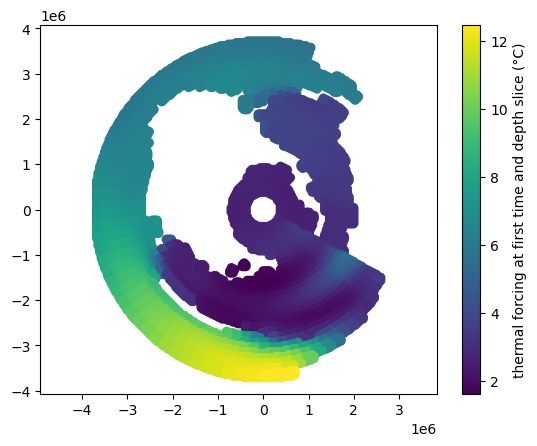

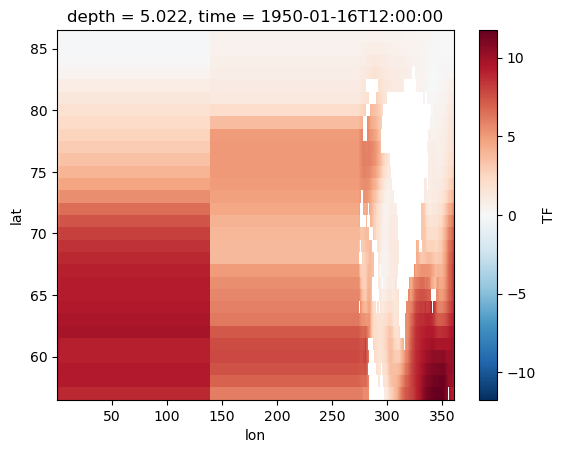

In [41]:
## plots to check things make sense

x_s, y_s = np.meshgrid(ds_polar.x, ds_polar.y)


plt.scatter(x_s, y_s, c=ds_polar.TF.sel(time='1950', method='nearest').values)
plt.colorbar(label='thermal forcing at first time and depth slice (°C)')
plt.axis('equal')
plt.show()

fig,ax = plt.subplots()
ds_en4.TF.sel(time='1950', depth=5.0, method='nearest').plot(ax=ax)
# fig,ax = plt.subplots()
# ax.scatter(x_s, y_s, c=ds_polar.TF.sel(time='1950', method='nearest').values)
# ax.colorbar(label='thermal forcing at first time and depth slice (°C)')
# ax.set(aspect=1)
# plt.show()

# plt.scatter(x_cmip, y_cmip, c=depth_cmip)
# plt.colorbar(label='max depth of non-NaN data in CMIP model (m)')
# plt.axis('equal')
# plt.show()


In [5]:
## match ismip points to cmip points

# linear versions of effective position arrays
X_eff_flat = X_eff.flatten()
Y_eff_flat = Y_eff.flatten()

# initialise arrays that will store the linear index of the required cmip point
x_ind = np.full_like(X_eff_flat, np.nan, dtype=float)
z_ind = np.full_like(X_eff_flat, np.nan, dtype=float)

# loop over effective depth grid
for k, z_val in enumerate(z):
    
    # get all ismip points with this effective depth
    i_inds = np.where(z_eff.flatten() == z_val)[0]

    # save the effective depth index
    z_ind[i_inds] = k

    # get all cmip points that have data at this depth
    c_inds = np.where(depth_cmip.flatten() <= z_val)[0]

    # loop over ismip points with this effective depth and find closest cmip point to effective position
    for i in i_inds:
        dsq = (x_cmip[c_inds] - X_eff_flat[i])**2 + (y_cmip[c_inds] - Y_eff_flat[i])**2
        id_min = np.argmin(dsq)
        x_ind[i] = c_inds[id_min]
    

In [6]:
## now we fill the ismip TF using the matched cmip positions and depths

# initialise array
TF_nop = np.full((len(t_cmip), len(x_ind)), np.nan)

# fill array knowing that the ismip TF(t,i) equals the cmip TF(t,z_ind(i),x_ind(i))
for i in range(len(x_ind)):
    if not np.isnan(x_ind[i]):
        TF_nop[:, i] = TF_nop_cmip[:, int(z_ind[i]), int(x_ind[i])]

# reshape array for consistency with ismip coordinates
TF_nop = TF_nop.reshape(len(t_cmip), X.shape[0], X.shape[1])


In [7]:
## final corrections

# correct for the freezing point dependence on pressure
TF = np.full_like(TF_nop, np.nan, dtype=float)
l3 = 7.61e-4; # dependence of freezing point on depth
for k in range(TF_nop.shape[0]):
    TF[k, :, :] = TF_nop[k, :, :] - l3 * z_eff
    
# check if any TF are less than 0 and fix
inds = np.where(TF < 0)
num_corrected = len(inds[0])
if num_corrected > 0:
    TF[inds] = 0
    print(f"Warning: {num_corrected} pixels corrected for TF<0")

# all the unconnected below sea level points must be assigned TF=0 -  these points have z_eff=NaN
TF[:, np.isnan(z_eff)] = 0

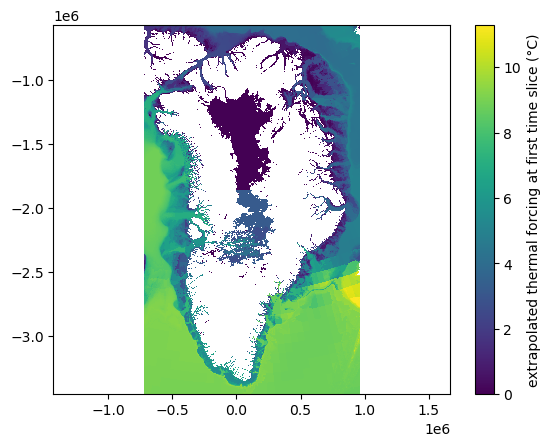

In [8]:
## plot an example of the result

plt.pcolormesh(X, Y, TF[0, :, :])
cbar = plt.colorbar()
cbar.set_label('extrapolated thermal forcing at first time slice (°C)')
plt.axis('equal')
plt.show()

In [9]:
## write to output file

# file name
output_file = 'TF_example_python.nc'

# delete previous file if it exists
if os.path.exists(output_file):
    os.remove(output_file)

# write netcdf
with Dataset(output_file, 'w', format='NETCDF4') as nc:

    # dimensions
    nc.createDimension('x', len(x))
    nc.createDimension('y', len(y))
    nc.createDimension('t', len(t_cmip))

    # variables
    x_var = nc.createVariable('x', np.float32, ('x',))  # 'f4' = single precision float
    y_var = nc.createVariable('y', np.float32, ('y',))
    t_var = nc.createVariable('t', np.float32, ('t',))
    TF_var = nc.createVariable('TF', np.float32, ('t', 'y', 'x'), zlib=True, complevel=9)

    # Write data
    x_var[:] = np.array(x, dtype=np.float32)
    y_var[:] = np.array(y, dtype=np.float32)
    t_var[:] = np.array(t_cmip, dtype=np.float32)
    TF_var[:, :, :] = np.array(TF, dtype=np.float32)
